In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
np.random.seed(1429)

In [2]:
df=pd.read_csv("Banking.csv")

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
df["Target"]=df.y

In [5]:
df=df.drop("y", axis=1)

In [6]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
#to find information values strictly for binary response and logistic regression
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [7]:
final_iv, IV = data_vars(df,df.Target)
final_iv

C:\Users\bishw\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,17,38,21175,2523,0.119150,18652,0.880850,0.543750,0.510343,0.063407,0.004479
1,age,39,98,20013,2117,0.105781,17896,0.894219,0.456250,0.489657,-0.070665,0.004479
2,job,admin.,admin.,10422,1352,0.129726,9070,0.870274,0.291379,0.248167,0.160525,0.188713
3,job,blue-collar,blue-collar,9254,638,0.068943,8616,0.931057,0.137500,0.235745,-0.539126,0.188713
4,job,entrepreneur,entrepreneur,1456,124,0.085165,1332,0.914835,0.026724,0.036445,-0.310243,0.188713
...,...,...,...,...,...,...,...,...,...,...,...,...
87,cons_conf_idx,-40.8,-26.9,17637,2611,0.148041,15026,0.851959,0.562716,0.411131,0.313863,0.092692
88,euribor3m,0.634,4.857,22055,3626,0.164407,18429,0.835593,0.781466,0.504241,0.438117,0.348544
89,euribor3m,4.858,5.045,19133,1014,0.052997,18119,0.947003,0.218534,0.495759,-0.819146,0.348544
90,nr_employed,4963.6,5191,21271,3542,0.166518,17729,0.833482,0.763362,0.485088,0.453402,0.342518


In [8]:
IV=IV.sort_values("IV",ascending=False)
IV=IV[IV.IV>=0.02]

[Text(0, 0, 'duration'),
 Text(0, 0, 'poutcome'),
 Text(0, 0, 'month'),
 Text(0, 0, 'euribor3m'),
 Text(0, 0, 'nr_employed'),
 Text(0, 0, 'emp_var_rate'),
 Text(0, 0, 'contact'),
 Text(0, 0, 'previous'),
 Text(0, 0, 'job'),
 Text(0, 0, 'default'),
 Text(0, 0, 'cons_price_idx'),
 Text(0, 0, 'cons_conf_idx'),
 Text(0, 0, 'education'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'marital')]

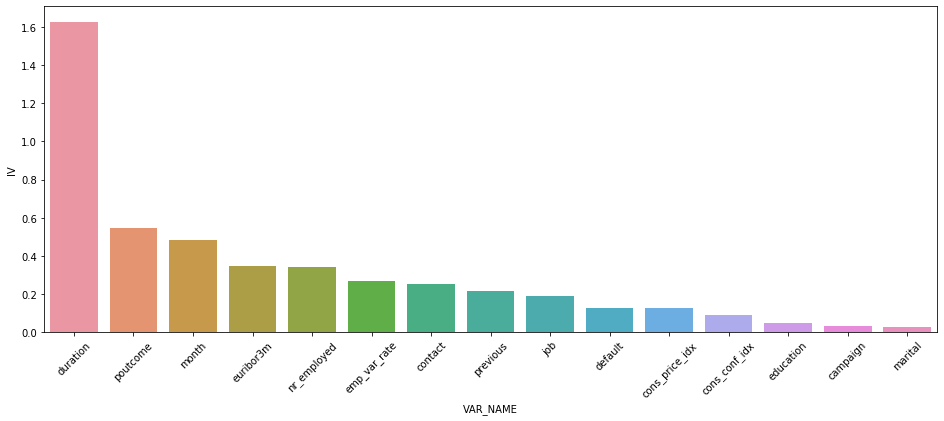

In [9]:
plt.figure(figsize=(16, 6))
ax=sns.barplot(x="VAR_NAME", y="IV",data=IV)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [10]:
IV

,VAR_NAME,IV
7,duration,1.625228
18,poutcome,0.547671
15,month,0.485117
10,euribor3m,0.348544
16,nr_employed,0.342518
9,emp_var_rate,0.269217
4,contact,0.251663
19,previous,0.217318
12,job,0.188713
6,default,0.127769


In [11]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'Target'],
      dtype='object')

In [12]:
df=df.loc[:,['duration',
 'poutcome',
 'month',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'contact',
 'previous',
 'job',
 'default',
 'cons_price_idx',
 'cons_conf_idx',
 'education',
 'campaign',
 'marital','Target']]

In [13]:
list(IV.VAR_NAME)

['duration',
 'poutcome',
 'month',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'contact',
 'previous',
 'job',
 'default',
 'cons_price_idx',
 'cons_conf_idx',
 'education',
 'campaign',
 'marital']

In [14]:
df.head()

,duration,poutcome,month,euribor3m,nr_employed,emp_var_rate,contact,previous,job,default,cons_price_idx,cons_conf_idx,education,campaign,marital,Target
0,210,nonexistent,aug,4.963,5228.1,1.4,cellular,0,blue-collar,unknown,93.444,-36.1,basic.4y,1,married,0
1,138,nonexistent,nov,4.021,5195.8,-0.1,cellular,0,technician,no,93.200,-42.0,unknown,1,married,0
2,339,success,jun,0.729,4991.6,-1.7,cellular,2,management,no,94.055,-39.8,university.degree,3,single,1
3,185,nonexistent,apr,1.405,5099.1,-1.8,cellular,0,services,no,93.075,-47.1,high.school,2,married,0
4,137,success,aug,0.869,5076.2,-2.9,cellular,1,retired,no,92.201,-31.4,basic.4y,1,married,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
duration          41188 non-null int64
poutcome          41188 non-null object
month             41188 non-null object
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
emp_var_rate      41188 non-null float64
contact           41188 non-null object
previous          41188 non-null int64
job               41188 non-null object
default           41188 non-null object
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
education         41188 non-null object
campaign          41188 non-null int64
marital           41188 non-null object
Target            41188 non-null int64
dtypes: float64(5), int64(4), object(7)
memory usage: 5.0+ MB


In [16]:
df.poutcome=df.poutcome.astype('category')
df.month=df.month.astype('category')
df.contact=df.contact.astype('category')
df.previous=df.previous.astype('category')
df.job=df.job.astype('category')
df.default=df.default.astype('category')
df.education=df.education.astype('category')
df.campaign=df.campaign.astype('category')
df.marital=df.marital.astype('category')

In [17]:
df.columns

Index(['duration', 'poutcome', 'month', 'euribor3m', 'nr_employed',
       'emp_var_rate', 'contact', 'previous', 'job', 'default',
       'cons_price_idx', 'cons_conf_idx', 'education', 'campaign', 'marital',
       'Target'],
      dtype='object')

In [18]:
sc=StandardScaler()

In [19]:
dum=pd.get_dummies(df.loc[:,[
 'poutcome',
 'contact',
 'previous',
 'job',
 'default',
 'education',
 'campaign',
 'marital']], drop_first=True)

In [20]:
df.drop(labels=["poutcome","month","contact","previous","job","default","education","campaign","marital"], axis=1, inplace=True)

In [21]:
df=pd.concat([df,dum], axis=1)

(6, 0)

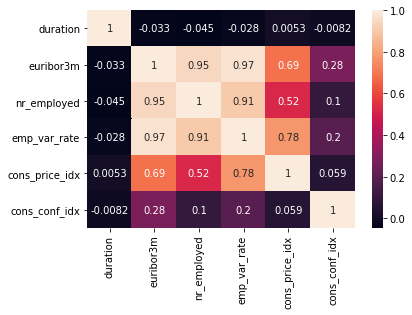

In [22]:
ax=sns.heatmap(df.loc[:,['duration', 'euribor3m', 'nr_employed', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx']].corr(), annot=True)
ax.set_ylim(6,0)

#euribor3m is highly correlated with nr_employed, emp_var_rate
#nr_employed is highly correlated with emp_var_rate
#emp_var_rate also has medium-high correlation with cons_price_idx

In [23]:
X=df.loc[:,['duration', 'euribor3m', 'nr_employed', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx','poutcome_nonexistent',
       'poutcome_success', 'contact_telephone', 'previous_1', 'previous_2',
       'previous_3', 'previous_4', 'previous_5', 'previous_6', 'previous_7',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'default_unknown', 'default_yes', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'campaign_2', 'campaign_3', 'campaign_4',
       'campaign_5', 'campaign_6', 'campaign_7', 'campaign_8', 'campaign_9',
       'campaign_10', 'campaign_11', 'campaign_12', 'campaign_13',
       'campaign_14', 'campaign_15', 'campaign_16', 'campaign_17',
       'campaign_18', 'campaign_19', 'campaign_20', 'campaign_21',
       'campaign_22', 'campaign_23', 'campaign_24', 'campaign_25',
       'campaign_26', 'campaign_27', 'campaign_28', 'campaign_29',
       'campaign_30', 'campaign_31', 'campaign_32', 'campaign_33',
       'campaign_34', 'campaign_35', 'campaign_37', 'campaign_39',
       'campaign_40', 'campaign_41', 'campaign_42', 'campaign_43',
       'campaign_56', 'marital_married', 'marital_single', 'marital_unknown']]
y=df.loc[:,"Target"]

In [24]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.015515,duration
1,65.792254,euribor3m
2,32.625107,nr_employed
3,39.185979,emp_var_rate
4,9.299639,cons_price_idx
...,...,...
75,1.000433,campaign_43
76,1.000354,campaign_56
77,2.569043,marital_married
78,2.638288,marital_single


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
print(vif.to_string())

       VIF Factor                       features
0        1.015515                       duration
1       65.792254                      euribor3m
2       32.625107                    nr_employed
3       39.185979                   emp_var_rate
4        9.299639                 cons_price_idx
5        2.927580                  cons_conf_idx
6   551362.626123           poutcome_nonexistent
7        1.470039               poutcome_success
8        2.095137              contact_telephone
9    70697.141923                     previous_1
10   11692.291715                     previous_2
11    3347.009977                     previous_3
12    1084.843280                     previous_4
13     279.646964                     previous_5
14      78.359711                     previous_6
15      16.403970                     previous_7
16       2.406326                job_blue-collar
17       1.137061               job_entrepreneur
18       1.183064                  job_housemaid
19       1.238845   

In [28]:
print(vif.loc[vif["VIF Factor"]<=4,].to_string())

    VIF Factor                       features
0     1.015515                       duration
5     2.927580                  cons_conf_idx
7     1.470039               poutcome_success
8     2.095137              contact_telephone
16    2.406326                job_blue-collar
17    1.137061               job_entrepreneur
18    1.183064                  job_housemaid
19    1.238845                 job_management
20    1.274355                    job_retired
21    1.121426              job_self-employed
22    1.424664                   job_services
23    1.162178                    job_student
24    1.760932                 job_technician
25    1.099958                 job_unemployed
26    1.073774                    job_unknown
27    1.127201                default_unknown
28    1.000918                    default_yes
29    1.502040             education_basic.6y
30    2.220987             education_basic.9y
31    3.357303          education_high.school
32    1.004816           education

In [29]:
list(vif.features)

['duration',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone',
 'previous_1',
 'previous_2',
 'previous_3',
 'previous_4',
 'previous_5',
 'previous_6',
 'previous_7',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_unknown',
 'default_yes',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'campaign_17',
 'campaign_18',
 'campaign_19',
 'campaign_20',
 'campaign

In [30]:
X=df.loc[:,['duration',
 'euribor3m',
 'nr_employed',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'poutcome_nonexistent',
 'poutcome_success',
 'contact_telephone',
 'previous_1',
 'previous_2',
 'previous_3',
 'previous_4',
 'previous_5',
 'previous_6',
 'previous_7',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'default_unknown',
 'default_yes',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'campaign_2',
 'campaign_3',
 'campaign_4',
 'campaign_5',
 'campaign_6',
 'campaign_7',
 'campaign_8',
 'campaign_9',
 'campaign_10',
 'campaign_11',
 'campaign_12',
 'campaign_13',
 'campaign_14',
 'campaign_15',
 'campaign_16',
 'campaign_17',
 'campaign_18',
 'campaign_19',
 'campaign_20',
 'campaign_21',
 'campaign_22',
 'campaign_23',
 'campaign_24',
 'campaign_25',
 'campaign_26',
 'campaign_27',
 'campaign_28',
 'campaign_29',
 'campaign_30',
 'campaign_31',
 'campaign_32',
 'campaign_33',
 'campaign_34',
 'campaign_35',
 'campaign_37',
 'campaign_39',
 'campaign_40',
 'campaign_41',
 'campaign_42',
 'campaign_43',
 'campaign_56',
 'marital_married',
 'marital_single',
 'marital_unknown']]
y=df.loc[:,"Target"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
X_train_skl=sc.fit_transform(X_train)
X_test_skl=sc.fit_transform(X_test)

In [33]:
glm=LogisticRegression()

In [34]:
glm.fit(X_train_skl, y_train)

C:\Users\bishw\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
Pred=glm.predict(X_test_skl)

In [36]:
from sklearn import metrics

In [37]:
print(metrics.confusion_matrix(y_test, Pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(glm.score(X_test, y_test)))

[[11694   340]
 [  938   621]]
Accuracy of logistic regression classifier on test set: 0.47


In [38]:
print(metrics.classification_report(y_test, Pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12034
           1       0.65      0.40      0.49      1559

    accuracy                           0.91     13593
   macro avg       0.79      0.69      0.72     13593
weighted avg       0.89      0.91      0.90     13593



In [39]:
AUC=metrics.roc_auc_score(y_test, Pred)
print("Area under curve {:.2f}". format(AUC))

Area under curve 0.69


In [40]:
fpr, tpr, th=metrics.roc_curve(y_test,glm.predict_proba(X_test_skl)[:,1] )

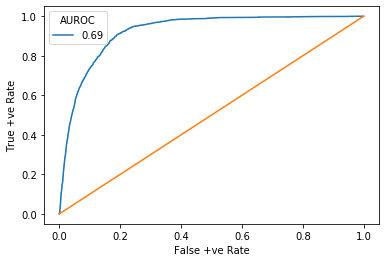

In [41]:
sns.lineplot(fpr,tpr)
sns.lineplot([0,1], [0,1])
plt.xlabel("False +ve Rate")
plt.ylabel("True +ve Rate")
plt.legend(title='AUROC', labels=[np.round(AUC,2)])

array([[11694,   340],
       [  938,   621]], dtype=int64)

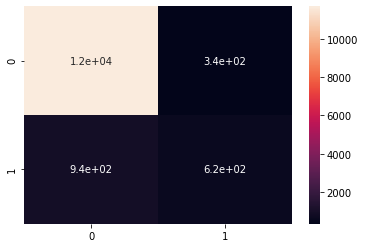

In [43]:
cm=metrics.confusion_matrix(y_test, Pred)
sns.heatmap(cm, annot=True)
plt.ylim(2,0)
cm

#Grid Search CV
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=1429)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 
max_features=['auto','sqrt','log2','None']
criterion=['gini','entropy']

from sklearn.model_selection import GridSearchCV

#n_estimators = [100, 300, 500, 800, 1200]
max_depth = [2,3,4]
#min_samples_split = [2, 5, 10, 15, 100]
#min_samples_leaf = [1, 2, 5, 10] 
max_features=['auto','sqrt','log2',None]
criterion=['gini','entropy']
bootstrap=[True,False]
hyperF = dict(#n_estimators = n_estimators, 
    max_depth = max_depth,  
              #min_samples_split = min_samples_split, 
             #min_samples_leaf = min_samples_leaf, 
    max_features=max_features, criterion=criterion, bootstrap=bootstrap)

gridF = GridSearchCV(rf, hyperF, cv = 10, 
                      n_jobs = 3)
bestF = gridF.fit(X_train, y_train)

print('Best Parameters using grid search: \n', 
      bestF.best_estimator_)

rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 30
max_estimators = 800

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(X_test, y_test)

    oob_error = 1 - rf.oob_score_
    error_rate[i] = oob_error

oob_series = pd.Series(error_rate)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.055, 
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05, 
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 10 to 1000 trees)')
